# Cuomo Donors, under the microscope!
This notebook describes all of the tools and methods used to identify and categorize Governor Cuomo's donors for the article "Real Estate Backs Cuomo" in the August edition of the Indypendent. It includes:
- Data cleaning
- Data analysis
- Open-source data
- Steps for creating other data used

In [1]:
#These are all the python libraries I used
import pandas as pd
import json
import requests
import warnings
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
import re
import numpy as np
from cycler import cycler
import squarify
import time
from selenium import webdriver
from sqlalchemy import create_engine
from collections import defaultdict

font = {'family' : 'helvetica',
        'size'   : 34}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
  'lines.linewidth': 0,
  'lines.solid_capstyle': 'butt',
  'legend.fancybox': True,
  'axes.prop_cycle': cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']),
  'axes.facecolor': '#f0f0f0',
  'axes.labelsize': 'large',
  'axes.axisbelow': True,
  'axes.edgecolor': '#f0f0f0',
  'axes.linewidth': .5,
  'axes.titlesize': 'x-large',
  'patch.edgecolor': '#f0f0f0',
  'patch.linewidth': 0.5,
  'svg.fonttype': 'path',
  'xtick.major.size': 0,
  'xtick.minor.size': 0,
  'ytick.major.size': 0,
  'ytick.minor.size': 0,
  'font.size': 24.0,
  'figure.subplot.left': 0.08,
  'figure.subplot.right': 0.95,
  'figure.subplot.bottom': 0.07,
  'figure.facecolor': '#f0f0f0',
})

# Cuomo Campaign Contributions from Board of Elections
Board of Elections (BOE) releases data in January and July: the data I use here came out 07/17/2018
* First, the tables (CSVs) were imported into Pandas to be able to work with the data in Python.
* then I take the dollar signs out of the 'Amount' column, ...and convert it to float so I can do calculations.
* I convert the 'Date' column to Pandas datetime, so I can sort and filter by date.

In [2]:
#This is the July 2018 BOE data
df1 = pd.read_csv("tabula-schedA.csv")
df2 = pd.read_csv("tabula-schedB.csv")
df3 = pd.read_csv("tabula-schedC.csv")
df4 = pd.read_csv("tabula-schedD.csv")

I want all of the columns to be the same, so here are the column names:

In [3]:
columns = {
    "NAME":"Donor",
    "ADDRESS":"Address",
    "DATE":"Date",
    "AMOUNT":"Amount"
}

# Table one (Schedule A) was a little bit different:
- The address was divided into street address, city, and state, instead of just address, like the other tables were.
- ...So, I standardize the column names:

In [4]:
df1.rename(columns={
    "NAME":"Donor",
    "ADDRESS":"Address",
    "DATE":"Date",
    "AMOUNT":"Amount",
    "CITY":"City",
    "STATE": "State"
},inplace=True)
df1['Address']=df1['Address'].str.strip()+' '+df1['City'].str.strip()
df1 = df1[['Date','Donor','Address','Amount']]

# Then I concatenate (stack end-to-end) all the tables together
Because we are interested in all campaign contributions, not just one schedule.
- So I make all of the column names the same
- Make the Addresses match
- Cycle through the list of tables and stick them together.

In [5]:
df_list = [df2, df3, df4]
for frame in df_list:
    frame.rename(columns=columns,inplace=True)
    frame['Address']=frame['Address'].str.strip()+' '+frame['Unnamed: 4'].str.strip()
    frame = frame[['Date','Donor','Address','Amount']]
    jul_df=pd.concat([df1, frame],ignore_index=True)

# I need to unify the date format
Python doesn't read 2002 and 02 the same, so I need to make sure all dates follow the same format.
- I chose 'mm/dd/yyyy'
- Pandas has a function for that, luckily!
- So first I read in the date, and then I change the format.
- I could have chosen 'm/dd/yy', but 'mm/dd/yyyy' matches the rest of the data I will use later.

In [6]:
jul_df['Date']=pd.to_datetime(jul_df['Date'], format ='%m/%d/%y' )
jul_df['Date']=jul_df['Date'].dt.strftime('%m/%d/%Y')

# I add Cuomo's campaign contributions from Board of Elections from all previous years.

- Available here:
- https://nyopengovernment.com/NYOG/index.jsp
- search "Andrew Cuomo".

In [7]:
df = pd.read_csv("Campaign_Contributions.csv")
df = df[['Donor','Address', 'Check No.', 'Amount', 'Date','Recipient', 'Fiscal Report']]

#Change the date format to 'mm/dd/yyyy'
df['Date']=pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df['Date']=df['Date'].dt.strftime('%m/%d/%Y')

# After selecting the columns I want and standardizing the date, I put the two datasets together
- Remove the $ sign from the Amount column, and make sure Python knows it's a floating-point decimal.
- Remove leading and following whitespace out of the Donor column, so it will match with other donors more easily.

In [8]:
df = jul_df.append(df, ignore_index=True)

df['Amount'] = df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
df['Donor'] = df['Donor'].str.strip()

# Now we have all of the donor data from Cuomo-- from attorney general to governor, up to July 16, 2018.
There is a sum total of $140,087,063.46: just names, check numbers, dates, and addresses. No industry/organization information yet.
- Who are they?
- What industries and groups own Cuomo?

In [9]:
#Starting point
df['Amount'].sum()

140087063.46

# If we look at top donors grouped by donor name, we get the picture of Cuomo's top donors that the Board of Elections lets us see.

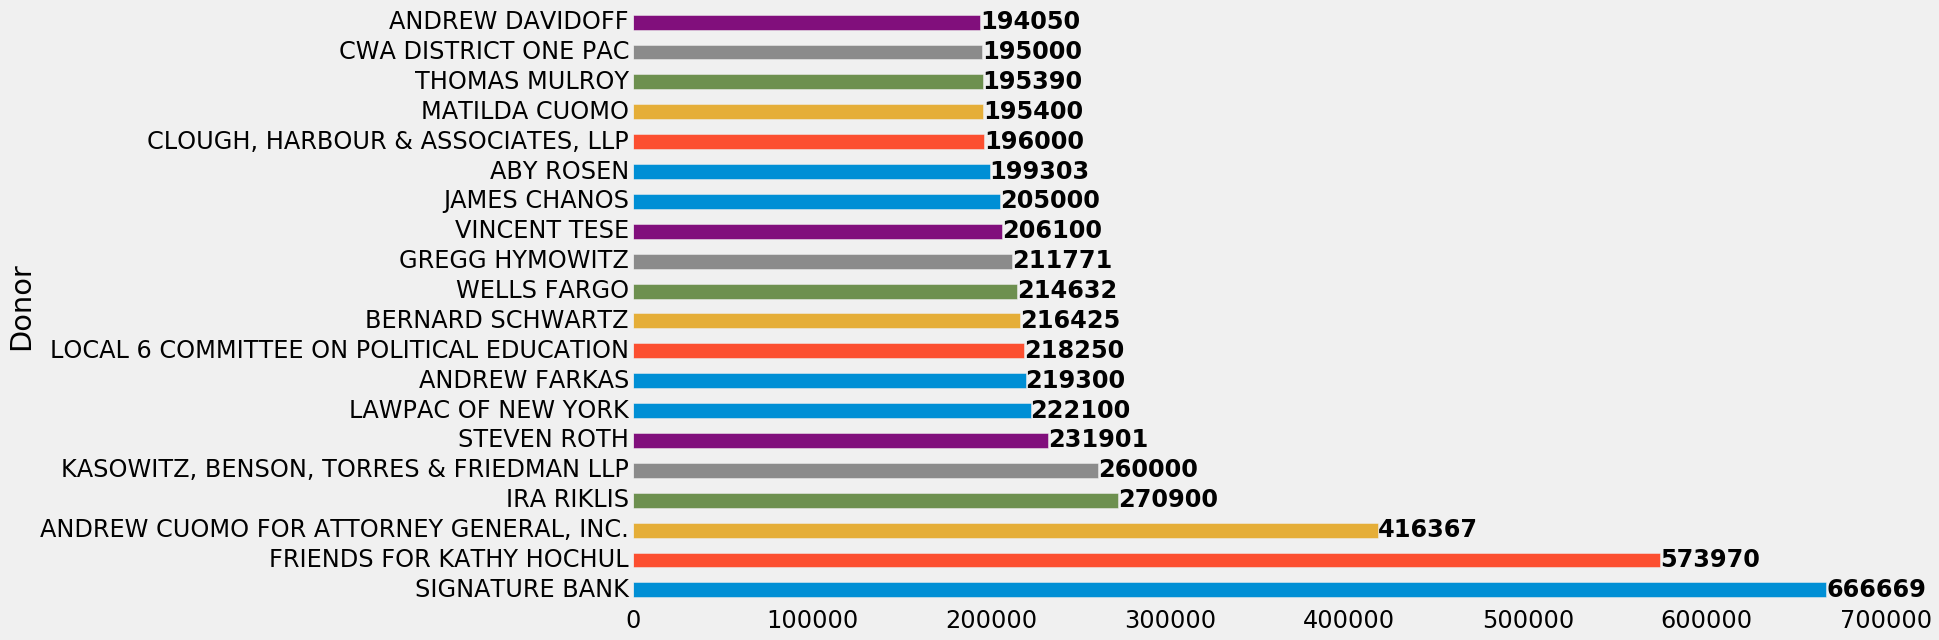

In [10]:
plt.figure(figsize=(20,10))
ax=df.groupby('Donor')['Amount'].sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='Donor', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')

*Signature bank*
- Ivanka Trump is on the board of directors
- Barney Frank is on the board of directors
- Ron Wasserman is an "associate group director", and is a member of AIPAC and chairman of Fuel for Truth, an anti-muslim think tank-funded org

*Kathy Hochul*
- Lieutenant governor of NYS
- "Friends for Kathy Hochul" receives money from LLC's, donates to Cuomo
- Kathy Hochul is heavily invested in the oil industry

*Kasowitz Benson Torres Friedman LLP*
- major RNC donor ($251,900)
- Trump donor
- https://projects.propublica.org/trump-town/organizations/kasowitz-benson-torres-friedman-llp !!!

# But wait!
### Shouldn't donors like Olga Rovt and Alexander Rovt (they're married) go together?
### Shouldn't we know that Dan Tishman is heavily invested in real estate?
### And if someone gives from an exact business address that is attributable to a company that has business before the State of New York, we should know. Cuomo does, after all.
### I'll need some way to match donors to industry and parent organizations.

## So I used data from Follow the Money, which has done extensive research on campaign donors.
I merge Follow the Money's matches with the current Board of Elections data data. This will help attribute Cuomo's donors to industries and parent organizations.

In [11]:
ftm_df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")
ftm_df = ftm_df.drop_duplicates('Original_Name', keep='first')
ftm_df['Original_Name'] = ftm_df['Original_Name'].str.strip() 
df = pd.merge(df, ftm_df, left_on='Donor', right_on='Original_Name', how='left', suffixes=['_boe','_ftm'])

## I am hoping that Cuomo's donors have many repeats over the years. ...So if they were matched in 2012, I'll find them in 2018.
This data analysis does not fact-check Follow the Money, instead building on their analysis.

# Follow the Money has a lot of data for each donor.
I just want these specific columns:

In [12]:
df = df[['Donor',
         'Address',
         'Check No.',
         'Amount_boe',
         'Date_boe',
         'Recipient',
         'Fiscal Report',
         'Filer',
         'Original_Name',
         'Contributor',
         'Type_of_Contributor',
         'Specific_Business',
         'General_Industry',
         'Broad_Sector',
         'City',
         'State',
         'Zip',
         'Parent_Org_or_Employer']]

In [13]:
print("Over the years, Glenwood has officially given", df[df['Parent_Org_or_Employer'].str.contains("GLENWOOD", na=False)]['Amount_boe'].sum(), "to Cuomo's campaign.")
print("My analysis shows that they have given much, much more through their various LLC's and officers.")

Over the years, Glenwood has officially given 889400.0 to Cuomo's campaign.
My analysis shows that they have given much, much more through their various LLC's and officers.


## But there are still many donors who have not been categorized.
I want to start attributing parent organizations to addresses and donor names.
> This was done using qualitative research, using Little Sis, Lexis Nexis, company records and SEC filings. Only exact matches were used: so if an address was not attributable to only one firm (as is the case with many NYC office buildings that rent to many tenants), it was not included.

In [14]:
def get_first_matches():
    #Nixon Peabody, LLP
    #The decision to include Nixon Peabody in the Real Estate bracket is problematic
    #They are a law firm, yet they are also members of REBNY.
    #so I choose to treat them as advocates for Real Estate
    df.loc[df.Address=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df.Address=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Real Estate'
    df.loc[df.Address=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df.Address=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("NIXON PEABODY", na=False), 'Parent_Org_or_Employer']='NIXON PEABODY LLP'
    df.loc[df.Donor.str.contains("NIXON PEABODY", na=False), 'General_Industry']='Real Estate'

    #Fisher Brothers
    df.loc[df.Donor.str.contains("FISHER BROTHERS", na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("FISHER BROTHERS", na=False), 'Parent_Org_or_Employer']='FISHER BROTHERS'
    df.loc[df.Address=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'General_Industry']='Real Estate'
    df.loc[df.Address=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'Parent_Org_or_Employer']='FISHER BROTHERS'

    #Brookfield
    brookfield = ['BOP MANAGEMENT SERVICES LLC',
                  'BOP AMTRAK HOLDINGS LLC',
                  'BOP AMTRAK OP LLC',
                  'BOP PROPERTIES HOLDINGS LLC']
    
    for brook in brookfield:
        df.loc[df.Donor==brook, 'General_Industry']='Real Estate'
        df.loc[df.Donor==brook, 'Parent_Org_or_Employer']='BROOKFIELD PROPERTY GROUP'

    #Longpoint Capital
    df.loc[df.Donor.str.contains("CLOUGH, HARBOUR", na=False), 'Parent_Org_or_Employer']='Longpoint Capital'
    df.loc[df.Donor.str.contains("CLOUGH, HARBOUR", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

    #NORSTAR
    df.loc[df.Donor.str.contains("NORSTAR", na=False), 'Parent_Org_or_Employer']='Norstar'
    df.loc[df.Donor.str.contains("NORSTAR", na=False), 'General_Industry']='Real Estate'
    

    #RXR, REXSCOTT
    rxr = ["REXSCOTT","RXR", "R X R REALTY"]
    for rx in rxr:
        df.loc[df.Donor.str.contains(rx, na=False), 'Parent_Org_or_Employer']='RXR REALTY'
        df.loc[((df.General_Industry == 'Uncoded') & (df.Donor.str.contains(rx))), 'General_Industry']='Real Estate'
    df.loc[df.Address=='625 RXR PLZ UNIONDALE, NY, 11556', 'Parent_Org_or_Employer']='RXR REALTY'
    df.loc[df.Address=='625 RXR PLZ UNIONDALE, NY, 11556', 'General_Industry']='Real Estate'

    #STV Incorporated
    stv = ["STV", "MILO RIVERSO","DOMINICK SERVEDIO", "WILLIAM MATTS"]
    for st in stv:
        df.loc[df.Donor==st, 'General_Industry']='Construction Services'
        df.loc[df.Donor==st, 'Parent_Org_or_Employer']='STV Incorporated'
    df.loc[df.Donor.str.contains(r"\bSTV\b", na=False), 'Parent_Org_or_Employer']='STV Incorporated'
    df.loc[df.Address=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'Parent_Org_or_Employer'] = 'STV Incorporated'
    df.loc[df.Address=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'General_Industry']='Construction Services'

    #Project Compassion
    df.loc[df.Address=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'General_Industry']='Nonprofit Institutions'
    df.loc[df.Address=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'Parent_Org_or_Employer']='Project Compassion'

    #List of subsidiaries of Cablevision, from: https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
    cablevision_list = ["1015 TIFFANY STREET", "1047 E 46TH STREET", "111 NEW SOUTH ROAD", "1111 STEWART",
    "1144 ROUTE 109 CORP.", "151 S. FULTON STREET", "2234 FULTON STREET", "389 ADAMS STREET", "4CONNECTIONS",
    "A-R CABLE SERVICES - NY", "BBHI HOLDINGS", "CCG HOLDINGS", "Clearview Cinemas", "CORAM ROUTE 112",
    "CSC ACQUISITION - MA", "CSC ACQUISITION - NY", "CSC ACQUISITION", "CSC GATEWAY", "CSC INVESTMENTS",
    "CSC MVDDS", "CSC NASSAU II", "CSC OPTIMUM HOLDINGS", "CSC T HOLDINGS I", "CSC T HOLDINGS II",
    "CSC T HOLDINGS III", "CSC T HOLDINGS IV", "CSC TECHNOLOGY", "CSC TKR",
    "CSC TRANSPORT II", "CSC TRANSPORT III", "CSC TRANSPORT", "CSC VT", "DTV NORWICH",
    "Clearband", "FROWEIN ROAD", "LIGHTPATH VOIP", "MSG VARSITY NETWORK", "MSG Varsity Network",
    "MSGVN", "N12N", "NEWS 12 COMPANY", "News 12", "NEWSDAY", "NMG HOLDINGS", "NY OV LLC", "PETRA CABLEVISION CORP.",
    "PRINCETON VIDEO IMAGE ISRAEL", "PVI HOLDINGS", "PVI PHILIPPINES", "PVI VIRTUAL MEDIA SERVICES",
    "RAINBOW MVDDS COMPANY", "RASCO HOLDINGS", "RMVDDS", "OMGFAST!", "SAMSON CABLEVISION CORP.",
    "SUFFOLK CABLE", "TELERAMA", "THE NEW YORK INTERCONNECT", "TRISTATE DIGITAL GROUP", "WIFI CT-NJ", "WIFI NY"]
    #https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
    for shell in cablevision_list:    
        df.loc[df.Donor.str.contains(shell, re.IGNORECASE, na=False), 'Parent_Org_or_Employer']='CABLEVISION SYSTEMS'
        df.loc[df.Donor.str.contains(shell, re.IGNORECASE, na=False), 'General_Industry']='Cable TV'

    df.loc[df.Donor == 'NY OV LLC', 'Parent_Org_or_Employer']='CABLEVISION SYSTEMS'
    df.loc[df.Donor == 'NY OV LLC', 'General_Industry']='Cable TV'


    #Anthony Bacchi
    #founder of Teli Stat, recipient of 5 million NY state grant, also CEO of Restorative Continuum, LLC
    df.loc[df.Donor=='RESTORATIVE CONTINUUM LLC', 'General_Industry']='Health Services'
    df.loc[df.Donor=='RESTORATIVE CONTINUUM LLC', 'Parent_Org_or_Employer']='Teli Stat'

    #Macquesten
    #Rella Fogliano is their president, Joseph Breda is their principal
    #Also '3300 KOSSUTH PARTNERS LLC' is a subsidiary: https://opengovus.com/new-york-state-corporation/4737731
    macquesten = ["RELLA FOGLIANO",
                  "JOSEPH BREDA",
                  "PALMER COURT ASSOCIATES, LLC"]
    for mac in macquesten:
        df.loc[df.Donor== mac, 'General_Industry']='Real Estate'
        df.loc[df.Donor== mac, 'Parent_Org_or_Employer']='MACQUESTEN DEVELOPMENT'
    
    macquesten_add = ['STE 100 438 FIFTH AVE PELHAM, NY, 10803',
                      'STE 100, 438 FIFTH AVE PELHAM, NY, 10803',
                      '438 FIFTH AVE PELHAM, NY, 10803']
    for mac_add in macquesten_add:
        df.loc[df.Address== mac_add, 'General_Industry']='Real Estate'
        df.loc[df.Address== mac_add, 'Parent_Org_or_Employer']='MACQUESTEN DEVELOPMENT'
    
    df.loc[df.Donor.str.contains("MACQUESTEN",na=False),'Parent_Org_or_Employer']='MACQUESTEN DEVELOPMENT'
    df.loc[df.Donor.str.contains("MACQUESTEN",na=False),'General_Industry']='Real Estate'

    
    #This address corresponds to Carson Equities, LLC:
    #http://carson-equities.com/contact/
    df.loc[df.Address== '4111 ANDOVER RD BLOOMFIELD TOWN, MI, 48302', 'General_Industry']= 'Real Estate'

    #STGG Realty LLC/Aro Holdings LLC
    df.loc[df.Donor=='STGG REALTY LLC', 'General_Industry']='Real Estate'
    df.loc[df.Donor=='STGG REALTY LLC', 'Parent_Org_or_Employer']='Aro Holdings LLC'

    #SFA
    df.loc[df.Address=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df.Address=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'Parent_Org_or_Employer']='SFA'

    #State Street Title Agency
    df.loc[df.Address=='2R 2413 3RD AVE BRONX, NY, 10451', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df.Address=='2R 2413 3RD AVE BRONX, NY, 10451', 'Parent_Org_or_Employer']='State Street Title Agency'

    #BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY
    df.loc[df.Address=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY'
    df.loc[df.Address=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'General_Industry']='General Contractors'

    #US Immigration Fund and Nicholas Mastroianni
    #Subject of letter to Kushner Companies: https://advance-lexis-com.ezproxy.cul.columbia.edu/document/?pdmfid=1516831&crid=6477e7ad-e14b-46dc-90ee-04cff06df089&pddocfullpath=%2Fshared%2Fdocument%2Fnews%2Furn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pddocid=urn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pdcontentcomponentid=247474&pdteaserkey=sr0&pditab=allpods&ecomp=cy3k&earg=sr0&prid=90da6d5c-476c-447a-b7a3-5c6610ef4ac9
    df.loc[df.Address=='80 STATE ST ALBANY, NY, 12207', 'Parent_Org_or_Employer']='US Immigration Fund'
    df.loc[df.Address=='80 STATE ST ALBANY, NY, 12207', 'General_Industry']='Securities & Investment'

    df.loc[df.Donor=='CONIFER REALTY LLC', 'Parent_Org_or_Employer']='Conifer Realty'
    df.loc[df.Donor=='CONIFER REALTY LLC', 'General_Industry']='Real Estate'
    
    #Triangle Equities
    df.loc[df.Address=='25 BONNIE HEIGHTS RD MANHASSET, NY, 11030', 'Parent_Org_or_Employer']='TRIANGLE EQUITIES'
    df.loc[df.Address=='25 BONNIE HEIGHTS RD MANHASSET, NY, 11030', 'General_Industry']='Real Estate'
    
    df.loc[df.Address=='25 BONNIE HEIGHTS ROAD MANHASSET, NY, 11030', 'Parent_Org_or_Employer']='TRIANGLE EQUITIES'
    df.loc[df.Address=='25 BONNIE HEIGHTS ROAD MANHASSET, NY, 11030', 'General_Industry']='Real Estate'
    
    #Extell
    df.loc[df.Donor=='AYALA BARNETT', 'Parent_Org_or_Employer']='EXTELL DEVELOPMENT COMPANY'
    df.loc[df.Donor=='AYALA BARNETT', 'General_Industry']='Real Estate'
    
    df.loc[df.Donor=='GARY BARNETT', 'Parent_Org_or_Employer']='EXTELL DEVELOPMENT COMPANY'
    df.loc[df.Donor=='GARY BARNETT', 'General_Industry']='Real Estate'
    
    #RFR
    df.loc[df.Donor=='RFR HOLDING LLC', 'Parent_Org_or_Employer']='RFR Holdings'
    df.loc[df.Donor=='RFR HOLDING LLC', 'General_Industry']='Real Estate'
    df.loc[df.Donor=='RFR HOLDINGS, CORPORATION', 'Parent_Org_or_Employer']='RFR Holdings'
    df.loc[df.Donor=='RFR HOLDINGS, CORPORATION', 'General_Industry']='Real Estate'
    
    #Dover Knolls Development
    df.loc[df.Donor=='DOVER KNOLLS DEVELOPMENT CO. II, LLC', 'Parent_Org_or_Employer']='Dover Knolls Development'
    df.loc[df.Donor=='DOVER KNOLLS DEVELOPMENT CO. II, LLC', 'General_Industry']='Real Estate'
    
    #Vanderbilt Holding Corp
    df.loc[df.Donor=='VANDERBILT HOLDING CORP.', 'Parent_Org_or_Employer']='R. T. Vanderbilt Holding Company, Inc.'
    df.loc[df.Donor=='VANDERBILT HOLDING CORP.', 'General_Industry']='Real Estate'
    
    #Marathon Development Group
    df.loc[df.Donor.str.contains("MARATHON DEVELOPMENT", na=False), 'Parent_Org_or_Employer']='Marathon Development Group'
    df.loc[df.Donor.str.contains("MARATHON DEVELOPMENT", na=False), 'General_Industry']='Real Estate'
    
    #Related
    df.loc[df.Donor.str.contains("BRUCE BEAL", na=False), 'Parent_Org_or_Employer']='RELATED COMPANIES, L.P.'
    df.loc[df.Donor.str.contains("BRUCE BEAL", na=False), 'General_Industry']='Real Estate'
    
    #The Benjamin Companies
    df.loc[df.Donor.str.contains("COURTHOUSE CORPORATE CENTER", na=False), 'Parent_Org_or_Employer']='The Benjamin Companies'
    df.loc[df.Donor.str.contains("COURTHOUSE CORPORATE CENTER", na=False), 'General_Industry']='Real Estate'


    
    

## In fact, there were so many REBNY member overlaps, I decided to scrape the REBNY directory so I could cross-reference with the contributions data.
- I used Selenium, a python library for web testing that is sometimes also used to scrape interactive pages, where you need to "click" a button, as in this case.

In [15]:
#LAST RUN 7/18/2018
def scrape_rebny():
    driver = webdriver.Chrome()

    driver.get('https://www.rebny.com/content/rebny/en/directory/complete-member-directory.html/')
    rebny_list = []
    first = True;
    for page in range(797):
        time.sleep(2)
        table = driver.find_element_by_class_name('list')
        page_list=[]
        try:
            table = table.find_element_by_tag_name('tbody')
            rows = table.find_elements_by_tag_name('tr')
            for row in rows:
                name = row.find_elements_by_tag_name('td')[0].text
                firm = row.find_elements_by_tag_name('td')[1].text
                page_list.append({'name': name,
                         'firm': firm})
        except:
            pass

        rebny_list.append(page_list)

        if first:
            next_button = driver.find_element_by_xpath('//*[@id="dirInner"]/div/a[8]')
            first = False;
            next_button.click()
        else:
            next_button = driver.find_element_by_xpath('//*[@id="dirInner"]/div/a[9]')
            next_button.click()

    frames = []
    for reb in rebny_list:
            frames.append(pd.DataFrame(reb))

    rebny_df = pd.concat(frames, ignore_index=True)
    rebny_df['rebny']=1
    rebny_df['name']=rebny_df['name'].str.upper()
    rebny_df['firm']=rebny_df['firm'].str.upper()
    rebny_df=rebny_df.drop_duplicates('name')
    rebny_df.to_csv("07182018rebny.csv")

## Real estate firms use many LLC's to donate unlimited amounts of money to Cuomo's political campaign. Glenwood, Resnick, Durst, Steiner, Roxann  all use many LLC's for their donations.

In [16]:
def get_re_matches():
    #Walison Corporation, Sabah Rajput
    df.loc[df.Donor=='1060 UNIVERSITY AVE LLC','General_Industry']='Real Estate'
    df.loc[df.Donor=='1060 UNIVERSITY AVE LLC','Parent_Org_or_Employer']='Walison Corporation'
    df.loc[df.Donor=='2238 CRESTON AVENUE LLC','General_Industry']='Real Estate'
    df.loc[df.Donor=='2238 CRESTON AVENUE LLC','Parent_Org_or_Employer']='Walison Corporation'

    #Glenwood has contributed lots to Cuomo under "Glenwood", but they also use shell LLC's to donate lots more!
    glenwood =['TRIBECA NORTH END LLC', 'BARCLAY STREET REALTY LLC',
               'LIBERTY STREET REALTY LLC', 'EAST 103RD STREET REALTY LLC',
               '92ND REALTY LLC', 'ARWIN 74TH STREET LLC',
               'EAST 72ND REALTY LLC', 'EAST 81ST REALTY, LLC'
               'EAST 85TH REALTY LLC', 'EAST 77TH REALTY LLC']
    for glen in glenwood:
        df.loc[df.Donor==glen, 'Parent_Org_or_Employer']='GLENWOOD'
        df.loc[df.Donor==glen, 'General_Industry']='Real Estate'

    df.loc[df.Address=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'Parent_Org_or_Employer']='GLENWOOD'
    df.loc[df.Address=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'General_Industry']='Real Estate'

    resnick = ['315 HUDSON LLC', '250 HUDSON STREET LLC',
               'RESNICK SEAPORT LLC','133 E 58TH STREET LLC',
               '161 WILLIAM STREET LLC','AB 40TH STREET LLC', 
               'RESNICK 255 GREENWICH LLC', 'RB 52 CO. LLC', 
               'DENNIS BRADY']

    for res in resnick:
        df.loc[df.Donor==res, 'Parent_Org_or_Employer']='RESNICK, JACK & SONS'
        df.loc[df.Donor==res, 'General_Industry']='Real Estate'

    #Durst
    esposito = ['DOLP 733 PROPERTIES LLC', 'DOLP 1155 PROPERTIES LLC',
                'DOLP 1133 PROPERTIES LLC','DOLP 675 PROPERTIES LLC',
                'DOLP 205 PROPERTIES LLC', 'DOLP 114 PROPERTIES LLC',
                'THE HELENA ASSOCIATES LLC', 'THE DURST ORGANIZATION, LP',
                'HELENA DURST', 'ALEXANDER DURST']
    for esp in esposito:
        df.loc[df.Donor==esp, 'Parent_Org_or_Employer']='DURST ORGANIZATION'
        df.loc[df.Donor==esp, 'General_Industry']='Real Estate'
    
    df.loc[df.Parent_Org_or_Employer == 'DURST ORGANIZATION', 'General_Industry']='Real Estate'

    #Steiner Equities Group
    steiner = ['25 WA ASSOCIATES LLC', '181 AVENUE A, LLC', '25WA ASSOCIATES, LLC']
    for stein in steiner:
        df.loc[df.Donor==stein, 'Parent_Org_or_Employer']='STEINER NYC, LLC'
        df.loc[df.Donor==stein, 'General_Industry']='Real Estate'
    df.loc[df.Address=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'Parent_Org_or_Employer']='STEINER NYC, LLC'
    df.loc[df.Address=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'General_Industry']='Real Estate'

    #Roxann Management Corp
    roxann = ['203 WEST 90TH STREET RETAIL LLC',
              '1628 SECOND AVENUE RETAIL LLC',
              '170 WEST 75TH STREET RETAIL LLC',
               '215 WEST 90TH STREET RETAIL LLC']
    for rox in roxann:
        df.loc[df.Donor==stein, 'Parent_Org_or_Employer']='Roxann Management Corp'
        df.loc[df.Donor==stein, 'General_Industry']='Real Estate'
    df.loc[df.Donor == 'CURTIS KATZ', 'Parent_Org_or_Employer']='Roxann Management Corp'
    df.loc[df.Donor == 'CURTIS KATZ','General_Industry']='Real Estate'    

    #Orbach Group
    orbach = ['BEACON 109 203-205, LLC', 'LIGHTHOUSE 49 LLC']
    for orb in orbach:
        df.loc[df.Donor==orb, 'Parent_Org_or_Employer']='Orbach Group'
        df.loc[df.Donor==orb, 'General_Industry']='Real Estate'
    df.loc[df.Donor=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'Parent_Org_or_Employer']='Orbach Group'
    df.loc[df.Donor=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'General_Industry']='Real Estate'

    #Atlantic Development Group
    atlantic = ['MARC ALTHEIM', 'PETER FINE',
                'KNICKERBOCKER MANAGEMENT LLC',
                'KNICKERBOCKER MANAGEMENT, LLC']
    for atl in atlantic:
        df.loc[df.Donor==atl, 'Parent_Org_or_Employer']='ATLANTIC DEVELOPMENT GROUP, LLC'
        df.loc[df.Donor==atl, 'General_Industry']='Real Estate'

    #MADDD Equities
    maddd = ["JACKSON BUILDERS, LLC",
             "ST. ANN'S CDE OWNER LLC",
             "MADDD EQUITIES LLC"]
    for mad in maddd:
        df.loc[df.Donor==mad, 'Parent_Org_or_Employer']='MADDD Equities'
        df.loc[df.Donor==mad, 'General_Industry']='Real Estate'


    #Clover, Michael Joseph, Howard Zemsky
    clover = ["10 SULTAN'S COURT BUFFALO, NY, 14221",
              "10 SULTAN'S COURT WILLIAMSVILLE, NY, 14221",
              "10 SULTANS CT WILLIAMSVILLE, NY, 14221",
              "348 HARRIS HILL ROAD WILLIAMSVILLE, NY, 14221"]

    for clov in clover:
        df.loc[df.Address==clov, 'Parent_Org_or_Employer']='Clover Construction'
        df.loc[df.Address==clov, 'General_Industry']='Real Estate'

    # FOUR M HOLDINGS
    df.loc[df.Donor.str.contains("MEHIEL", na=False), 'Parent_Org_or_Employer']='Four M Holdings'
    df.loc[df.Donor.str.contains("MEHIEL", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
    df.loc[df.Donor == 'FOUR M CAPITAL, LLC', 'Parent_Org_or_Employer']='Four M Holdings'
    df.loc[df.Donor=='FOUR M FRANCHISING, LLC', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

    # Rovt
    df.loc[df.Donor.str.contains(r"ROVT$", na=False), 'Parent_Org_or_Employer']='Rovt'
    
    #RENAISSANCE EQUITY LLC
    df.loc[df.Donor == 'RENAISSANCE EQUITY LLC', 'Parent_Org_or_Employer']='RENAISSANCE EQUITY'
    df.loc[df.Donor=='RENAISSANCE EQUITY LLC', 'General_Industry']='Real Estate'
    
    #Triangle Equities
    df.loc[df.Address== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'General_Industry']='Real Estate'
    df.loc[df.Address== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'Parent_Org_or_Employer']='TRIANGLE EQUITIES'
    df.loc[df.Donor.str.contains("PETRACCA",na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("PETRACCA",na=False), 'Parent_Org_or_Employer']='TRIANGLE EQUITIES'

## on paper, REBNY showers money on Cuomo with PACs. But also through its members!
+ REBNY firm members-- especially its executive committee-- also give money individually.
+ Typically they give money themselves; their firms give money; and their families give money. So how much does an organization like Durst really give?
+ First I'll match some names from qualitative research.
+ Then I'll join my data with the member list I scraped from REBNY; exact matches on donor name will relate any uncategorized donors to their parent organization.


In [17]:
def get_rebny_matches():
    #MEMBERS
    #Related- Bruce Beal
    df.loc[df.Donor.str.contains("BRUCE BEAL", na=False), 'Parent_Org_or_Employer']='RELATED COMPANIES, L.P.'
    df.loc[df.Donor.str.contains("BRUCE BEAL", na=False), 'General_Industry']='Real Estate'

    #Extell- Gary Barnett
    df.loc[df.Donor.str.contains("GARY BARNETT", na=False), 'Parent_Org_or_Employer']='EXTELL DEVELOPMENT COMPANY'
    df.loc[df.Donor.str.contains("GARY BARNETT", na=False), 'General_Industry']='Real Estate'

    #The Brodsky Organization- Daniel Brodsky
    df.loc[df.Address=='FL 3 400 W 59TH ST NEW YORK, NY, 10019', 'Parent_Org_or_Employer']='THE BRODSKY ORGANIZATION'
    df.loc[df.Address=='FL 3 400 W 59TH ST NEW YORK, NY, 10019', 'General_Industry']='Real Estate'
    df.loc[df.Address=='26 HARBOR PARK DR PORT WASHINGTON, NY, 11050', 'Parent_Org_or_Employer']='THE BRODSKY ORGANIZATION'
    df.loc[df.Address=='26 HARBOR PARK DR PORT WASHINGTON, NY, 11050', 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains(r"BRODSKY$", na=False), 'Parent_Org_or_Employer']='THE BRODSKY ORGANIZATION'
    df.loc[df.Donor.str.contains(r"BRODSKY$", na=False), 'General_Industry']='Real Estate'
    
    #BFC Partners- Donald Capoccia
    df.loc[df.Donor.str.contains("CAPOCCIA", na=False), 'Parent_Org_or_Employer']='BFC PARTNERS'
    df.loc[df.Donor.str.contains("CAPOCCIA", na=False), 'General_Industry']='Real Estate'            

    #Rockrose Development Corp. and TF Cornerstone Inc.
    df.loc[df.Donor.str.contains("ELGHANA", na=False), 'Parent_Org_or_Employer']='ELGHANAYAN FAMILY'
    df.loc[df.Donor.str.contains("ELGHANA", na=False), 'General_Industry']='Real Estate' 

    #Fetner Properties Inc.- Harold A. Fetner and Sondra Fetner
    df.loc[df.Donor.str.contains("SONDRA FETNER", na=False), 'Parent_Org_or_Employer']='FETNER PROPERTIES INC'
    df.loc[df.Donor.str.contains("SONDRA FETNER", na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("HAROLD A. FETNER", na=False), 'Parent_Org_or_Employer']='FETNER PROPERTIES INC'
    df.loc[df.Donor.str.contains("HAROLD A. FETNER", na=False), 'General_Industry']='Real Estate'

    #Newmark Knight Frank- Barry Gosin and Jackie Gosin
    df.loc[df.Donor.str.contains("GOSIN", na=False), 'Parent_Org_or_Employer']='NEWMARK KNIGHT FRANK'
    df.loc[df.Donor.str.contains("GOSIN", na=False), 'General_Industry']='Real Estate'

    #SL Green- Stephen Green and Marc Holliday
    df.loc[df.Donor.str.contains("SL GREEN", na=False), 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df.Donor.str.contains("SL GREEN", na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor=='STEPHEN GREEN', 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df.Donor=='STEPHEN GREEN', 'General_Industry']='Real Estate'
    df.loc[df.Donor=='MARC HOLLIDAY', 'Parent_Org_or_Employer']='SL GREEN REALTY CORP.'
    df.loc[df.Donor=='MARC HOLLIDAY', 'General_Industry']='Real Estate'

    #GF Real Estate LLP- JEFFREY GURAL
    df.loc[df.Donor=='JEFFRY GURAL', 'Parent_Org_or_Employer']='GFP REAL ESTATE LLC'
    df.loc[df.Donor=='JEFFRY GURAL', 'General_Industry']='Real Estate'
    #Kalikow, H.J. & Co., LLC: the whole family, it seems
    kalikow=['H.J. KALIKOW & CO LLC', 'MARY KALIKOW',
             'PETER KALIKOW','KALIKOW CONSTRUCTION SERVICES']
    for kow in kalikow:
        df.loc[df.Donor==kow, 'Parent_Org_or_Employer']='KALIKOW, H.J. & CO., LLC'
        df.loc[df.Donor==kow, 'General_Industry']='Real Estate'

    #Two Trees Management Company, LLC
    df.loc[df.Donor.str.contains("TWO TREES", na=False), 'Parent_Org_or_Employer']='TWO TREES MANAGEMENT CO. LLC'
    df.loc[df.Donor.str.contains("TWO TREES", na=False), 'General_Industry']='Real Estate'

    #Sterling Equities - Fred Wilpon
    df.loc[df.Donor.str.contains("STERLING EQUITIES", na=False),'Parent_Org_or_Employer']='STERLING EQUITIES, INC.'
    df.loc[df.Donor.str.contains("STERLING EQUITIES", na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("SAUL KATZ", na=False),'Parent_Org_or_Employer']='STERLING EQUITIES, INC.'
    df.loc[df.Donor.str.contains("SAUL KATZ", na=False), 'General_Industry']='Real Estate'
    df.loc[df.Donor.str.contains("DAVID KATZ", na=False),'Parent_Org_or_Employer']='STERLING EQUITIES, INC.'
    df.loc[df.Donor.str.contains("DAVID KATZ", na=False), 'General_Industry']='Real Estate'

    #Tishman -- at 666 5th Avenue, Kushner's building (until bought by Brookfield)
    tishman=["TISHMAN SPEYER DEVELOPMENT, LLC","TISHMAN SPEYER DEVELOPMENT LLC"]
    for tish in tishman:
        df.loc[df.Donor==tish, 'Parent_Org_or_Employer']='TISHMAN SPEYER'
        df.loc[df.Donor==tish, 'General_Industry']='Real Estate'
    
    df.loc[df.Donor.str.contains(r'SPEYER$',na=False), 'Parent_Org_or_Employer']='TISHMAN SPEYER'
    df.loc[df.Donor.str.contains(r'SPEYER$', na=False), 'General_Industry']='Real Estate'
    
    #Tishman Construction
    tishcons=["DAN TISHMAN",
              "SHERYL CRO TISHMAN",
              "SHERYL TISHMAN",
              "JOHN TISHMAN",
              "SHERYL TISHMAN",
              "TISHMAN CONSTRUCTION CORP OF NY"]
    
    for tishcon in tishcons:
        df.loc[df.Donor==tishcon, 'Parent_Org_or_Employer']='TISHMAN CONSTRUCTION'
        df.loc[df.Donor==tishcon, 'General_Industry']='Real Estate'

    #Lalezarian Properties LLC- Frank and Kevin Lalezarian
    df.loc[df.Address.str.contains('2 SPLIT ROCK DRIVE KINGS',na=False), 'Parent_Org_or_Employer']='LALEZARIAN PROPERTIES LLC'
    df.loc[df.Address.str.contains('2 SPLIT ROCK DRIVE KINGS',na=False), 'General_Industry']='Real Estate'
    
    #The Moinian Group
    df.loc[df.Address=='FL 23, 3 COLUMBUS CIR NEW YORK', 'Parent_Org_or_Employer']='THE MOINIAN GROUP'
    df.loc[df.Address=='FL 23, 3 COLUMBUS CIR NEW YORK', 'General_Industry']='Real Estate'
    df.loc[df.Address=='FL 23 3 COLUMBUS CIR NEW YORK, NY, 10019', 'Parent_Org_or_Employer']='THE MOINIAN GROUP'
    df.loc[df.Address=='FL 23 3 COLUMBUS CIR NEW YORK, NY, 10019', 'General_Industry']='Real Estate'
    df.loc[df['Donor'].str.contains(r"MOINIAN$",na=False), 'Parent_Org_or_Employer']='THE MOINIAN GROUP'
    df.loc[df['Donor'].str.contains(r"MOINIAN$",na=False), 'General_Industry']='Real Estate'
    
    #METROPOLITAN ASSET GROUP LTD
    df.loc[df.Donor == 'METROPOLITAN ASSET GROUP LTD', 'Parent_Org_or_Employer']='METROPOLITAN ASSET GROUP LTD'
    df.loc[df.Donor == 'METROPOLITAN ASSET GROUP LTD', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

## They also give money through PACs.

In [18]:
def get_pac_matches():
    #REBNY PAC, their political arm, "Real Estate Board PAC"
    df.loc[df.Donor.str.contains("REAL ESTATE BOARD", na=False), 'Parent_Org_or_Employer']='REBNY'
    df.loc[df.Donor.str.contains("REAL ESTATE BOARD", na=False), 'General_Industry']='Real Estate'

    #NYSAFAH has a PAC, 'Affordable Housing PAC, Ltd.'
    df.loc[df.Donor.str.contains("AFFORDABLE HOUSING PAC", na=False), 'Parent_Org_or_Employer']='NYSAFAH'
    df.loc[df.Donor.str.contains("AFFORDABLE HOUSING PAC", na=False), 'General_Industry']='Real Estate'

    #Also has NYSAFAH PAC LTD.
    df.loc[df.Donor=='NYSAFAH PAC LTD.', 'Parent_Org_or_Employer']='NYSAFAH'
    df.loc[df.Donor=='NYSAFAH PAC LTD.', 'General_Industry']='Real Estate'
    df.loc[df.Address=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'General_Industry']= 'Real Estate'
    df.loc[df.Address=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='NYSAFAH'

    #RPAC OF NEW YORK STATE- "Realtor PAC"
    df.loc[df.Donor.str.contains("RPAC OF NEW YORK STATE", na=False), 'Parent_Org_or_Employer']='Realtors PAC'
    df.loc[df.Donor.str.contains("RPAC OF NEW YORK STATE", na=False), 'General_Industry']='Real Estate'
    
    #RSA PAC
    df.loc[df.Donor=="RSA PAC", 'Parent_Org_or_Employer']='RSA PAC'
    df.loc[df.Donor=="RSA PAC", 'General_Industry']='Real Estate'

## RSA may also have many donors in common with Cuomo.
...But they don't publish their member list. Whistleblowers get at me!

In [19]:
def get_rsa_matches():
    #Ditmas Management - Sanford Sirulnick, Aaron Sirulnick, his son, is RSA chairman of the board
    df.loc[df.Donor.str.contains("SIRULNICK", na=False), 'Parent_Org_or_Employer']='RSA Ditmas Management'
    df.loc[df.Donor.str.contains("SIRULNICK", na=False), 'General_Industry']='Real Estate'

    #Howard Milstein - CEO of New York Private Bank; Chairman of Emigrant Capital
    df.loc[df.Donor.str.contains(r"MILSTEIN$", na=False), 'Parent_Org_or_Employer']='RSA Emigrant Capital'
    df.loc[df.Donor.str.contains(r"MILSTEIN$", na=False), 'General_Industry']='Real Estate'

    #Michael Kerr - RSA Boardmember, what else?
    df.loc[df.Donor=="MICHAEL KERR", 'Parent_Org_or_Employer']='RSA'
    df.loc[df.Donor=="MICHAEL KERR", 'General_Industry']='Real Estate'
    
    #Vornado
    df.loc[df.Donor=="DARYL ROTH",'Parent_Org_or_Employer']='VORNADO REALTY TRUST'
    df.loc[df.Donor=="DARYL ROTH",'General_Industry']='Real Estate'
    
    rsa_list = ['RSA','RSA-PAC INC', 'RSA-PAC','RSA-PAC INC.','RSA - PAC',
    'RENT STABILIZATION ASSOCIATION PAC','RENT STABILIZATION PAC','RENT STABILIZATION ASSOCIATION (RSA) PAC',
    'RENT STABILIZATION ASSOC.','NEIGHBORHOOD PRESERVATION FUND','NEIGHBORHOOD PRESERVATION','NEIHBORHOOD PRESERATION',
    'NEIGHBORHOOD PRESERVATION POLITICAL ACTION FUND','NEIGHBORHOOD PRESERVATION POLI']
    
    for rsa in rsa_list:
        df.loc[df.Donor==rsa, 'Parent_Org_or_Employer']='RSA'
        df.loc[df.Donor==rsa, 'General_Industry']='Real Estate'

In [20]:
def get_last_matches():
    #About fifteen firms that are uncoded and have realty in their name. They are definitely Real Estate.
    df.loc[(df.General_Industry.str.contains("Uncoded",na=False))&\
           (df.Donor.str.contains("REALTY", na=False)), 'General_Industry']='Real Estate'
    
    #Eastdil Secured is a "premier real estate investment bank"
    df.loc[df.Address=='40 WEST 57TH STREET NEW YORK, NY, 10019', 'Parent_Org_or_Employer']='Eastdil Secured'
    df.loc[df.Address=='40 WEST 57TH STREET NEW YORK, NY, 10019', 'General_Industry']='Real Estate'

    #Richman Group
    df.loc[df.Address=='340 PEMBERWICK ROAD GREENWICH, CT, 06831', 'Parent_Org_or_Employer']='Richman Group'
    df.loc[df.Address=='340 PEMBERWICK ROAD GREENWICH, CT, 06831', 'General_Industry']='Real Estate'

In [21]:
#Here's the list of REBNY firms/members from their member directory that I scraped
rebny_df = pd.read_csv("rebny.csv")
rebny_df = rebny_df.drop_duplicates('name', keep='first')
df = pd.merge(df, rebny_df, left_on='Donor', right_on='name', how='left')
df['Date']= df.Date_boe.apply(lambda x: pd.to_datetime(x).strftime('%m/%d/%Y')[0])
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)
df.head()

,Donor,Address,Check No.,Amount_boe,Date_boe,Recipient,Fiscal Report,Filer,Original_Name,Contributor,...,General_Industry,Broad_Sector,City,State,Zip,Parent_Org_or_Employer,Unnamed: 0,firm,name,rebny
Date,,,,,,,,,,,,,,,,,,,,,
0,JORGE MADRUGA,18 E GATE RD PORT WASHINGTON,NaN,10000.0,01/17/2018,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,WILLIAM BENFANTI,"91 REPPEIN PLACE ORCHARD PARK, NY, 14127",786,500.0,05/19/2009,ANDREW CUOMO 2018 INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MARK CHUNA,"1150 FIFTH AVENUE NEW YORK, NY, 10128",1460,500.0,04/20/2001,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ALAN ZUCCARI,"4100 MONUMENT DRIVE FAIRFAX, VA, 22030",33775,500.0,04/02/2009,ANDREW CUOMO 2018 INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MOGULL REALTY,"725 FIFTH AVENUE NEW YORK, NY, 10022",1308,500.0,06/14/2006,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,Periodic July,"CUOMO, ANDREW M",MOGULL REALTY,MOGULL REALTY,...,Real Estate,"Finance, Insurance & Real Estate",NEW YORK,NY,10022.0,NaN,NaN,NaN,NaN,NaN


In [22]:
reb_list = list(set(rebny_df['firm']))
#Also, if they're in REBNY, categorize as REBNY. And anyone in REBNY is categorized as Real Estate.
df.loc[df['Parent_Org_or_Employer'].isin(reb_list),'rebny']=1
df.loc[df['Parent_Org_or_Employer'].isin(reb_list),'General_Industry']='Real Estate'

In [23]:
df['Parent_Org_or_Employer']=df['Parent_Org_or_Employer'].astype(object).fillna('Unknown')
def fill_parent(row):
    if row['Parent_Org_or_Employer']=='Unknown':
        return row['firm']
    else:
        return row['Parent_Org_or_Employer']

In [24]:
df.Parent_Org_or_Employer = df.apply(fill_parent, axis=1)

In [25]:
rec = df['01-01-2017':]
print("Sum from Real Estate 2017-2018:", "${:,}".format(rec[rec.General_Industry=='Real Estate']['Amount_boe'].sum()))
print("Sum from Lawyers, Lobbyists and Trade unions 2017-2018:", "${:,}".format(rec[rec['General_Industry']=='Lawyers & Lobbyists']['Amount_boe'].sum()))


Sum from Real Estate 2017-2018: $1,412,721.0
Sum from Lawyers, Lobbyists and Trade unions 2017-2018: $1,256,645.0


## Well, I'd like to see what the parent org breakdown is for the real estate industry.
- Hopefully the REBNY list helped make that clearer:

In [27]:
#Checking for any donors in common with the RSA PAC: didn't find any!

rsa_df = pd.read_csv("RSA-PAC-cleaned.csv")
rsa_df['Amount'] = rsa_df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
rsa_df['Name'] = rsa_df['Name'].str.strip()
rsa_df['Address']=rsa_df['Address'].str.strip()+' '+rsa_df['City'].str.strip()+' '+rsa_df['State'].str.strip()

rsa_add=list(set(rsa_df['Address']))
rsa_ind=list(set(rsa_df['Name']))

## Next I'm going to cross-reference the list of Cuomo donor LLCs with a nyc-db to see if there are any matches. It's not a big deal that they're in the DOB JOBS database, but they have to report an owner name: and that ownername might be in the REBNY or RSA list I have, or be connected to another donor already in BOE data.

## So I can answer the question: how many landlords used their shell LLC's for managing buildings, and also for donating to Cuomo?

I start by running the cuomo_llc_list.csv file through nyc-db's dobjobs table, to find exact matches-- this will be a "minimum" number. I find 132 unique LLCs that are both Cuomo donors and landlord LLCs.

In [28]:
#These are the LLC's I get by matching directly in SQL.
df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

132

## But for a more exhaustive list, I'm going to need a list of all the LLC's in New York City.

That looks like about 175,000 unique LLCs. I'm going to match them up to the Cuomo LLC's.
I run the following query on my local copy of nyc-db to get all of the LLC's from DOBJOBS in New York:

```CREATE TABLE nyc_llc AS SELECT ownersbusinessname, bbl, address FROM dobjobs WHERE ownersbusinessname LIKE('%LLC%') GROUP BY ownersbusinessname, bbl, address                                                                 ;
SELECT 175564
```

## I want more granular information on each LLC, how much they've given to Cuomo and when. 

So I won't just check to see if they match to some LLC in Cuomo's donor list: but confirm exactly which one(s) they match.

In [29]:
unknown_llc_number = df[(df['Donor'].str.contains('LLC'))|\
            (df['Broad_Sector']=='Unknown')|\
            (df['General_Industry']=='Unknown')|\
            (df['Specific_Business']=='Unknown')|\
            (df['Parent_Org_or_Employer']=='Unknown')]\
            ['Donor'].nunique()

llc_list = df[(df['Donor'].str.contains('LLC')) |\
            (df['Broad_Sector']=='Unknown')|\
            (df['General_Industry']=='Unknown')|\
            (df['Specific_Business']=='Unknown')|\
            (df['Parent_Org_or_Employer']=='Unknown')]

#Here I checked the LLC names against the LLCs listed in DOBJOBS

llc_list.columns = [c.lower() for c in llc_list.columns]
#postgres doesn't like capitals or spaces

engine = create_engine('postgresql://GeorgiaKromrei@localhost:5432/housing_data_analysis')

llc_list.to_sql("cuomo_llc_list", engine, if_exists="replace")
print("I'm loading", llc_list['donor'].nunique(), "unique LLC names into nyc-db for cross-referencing.")

#These are the LLC's I get by matching directly in SQL.

df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

#If I use Python, I get a few more

nyc_llc = pd.read_csv('nyc_llc.csv')
nyc_llc['businessname_nollc'] = nyc_llc['ownersbusinessname'].str.upper().str.replace(r',? LLC.*','')
llc_list['donorname_nollc'] = llc_list['donor'].str.replace(r',? LLC.*','')

unique = llc_list[llc_list['donorname_nollc'].isin(nyc_llc['businessname_nollc'])]['donor'].nunique()

print("There are", unique, '''unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified by\
either Follow the Money or the Board of Elections.''')

llc_list = llc_list.merge(nyc_llc, right_on='businessname_nollc', left_on='donorname_nollc', how='inner')
llc_list.drop_duplicates('check no.', keep='first', inplace=True)
llc_list.ownername = llc_list.ownername.str.upper().str.replace("ESPOISTO", "ESPOSITO")\
                                        .str.replace("EDWARD KAMIN", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKI", "EDWARD KAMINSKY")\
                                        .str.replace("TIVADAR MARCOVICI", "TIVADAR MARCOVICCI")\
                                        .str.replace("EDWARD KAMINSKYSKI", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKYSKY", "EDWARD KAMINSKY")\
                                        .str.replace("JOHNATHAN", "JONATHAN")\
                                        .str.replace("PETRACCA LESTER", "LESTER PETRACCA")\
                                        .str.replace("LOIS ESPOSITO", "LOUIS ESPOSITO")\
                                        .str.replace("LEONARD LITWIM", "LEONARD LITWIN")
llc_list=llc_list[['donor','ownername', 'ownersbusinessname','address_y','ownersphone']]

llc_list.rename(columns={
    "ownername":"dob_ownername",
    "address_y":"dob_address",
    "ownersphone":"dob_ownersphone",
    "ownersbusinessname":"dob_business"
},inplace=True)

I'm loading 1681 unique LLC names into nyc-db for cross-referencing.
There are 218 unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified byeither Follow the Money or the Board of Elections.


## Landlords use LLC's to make filings with the Department of Buildings, and also to donate to Cuomo. But the DOB filings list the LLC owner name, so I can see who owns the LLCs that happen to be in both.

In [30]:
df.Original_Donor=df.Donor
llc_list = llc_list.drop_duplicates('donor', keep='first')
df = pd.merge(df, llc_list, left_on='Donor', right_on='donor', how='left')

In [31]:
get_first_matches()
get_re_matches()
get_rebny_matches()
get_rsa_matches()
get_pac_matches()
get_last_matches()

In [32]:
def transform_row(row):
    if not pd.isnull(row.dob_business):
        row.Donor=row.dob_business
    return row
        
df = df.apply(transform_row,axis=1)

In [33]:
get_first_matches()
get_re_matches()
get_rebny_matches()
get_rsa_matches()
get_pac_matches()
get_last_matches()

In [34]:
df['Amount_boe'].sum()

140087063.45999998

In [35]:
df['Date']=pd.to_datetime(df['Date_boe'], infer_datetime_format=True,errors='coerce')
df['Donation_Date']=df['Date']
df.set_index('Date', inplace=True)

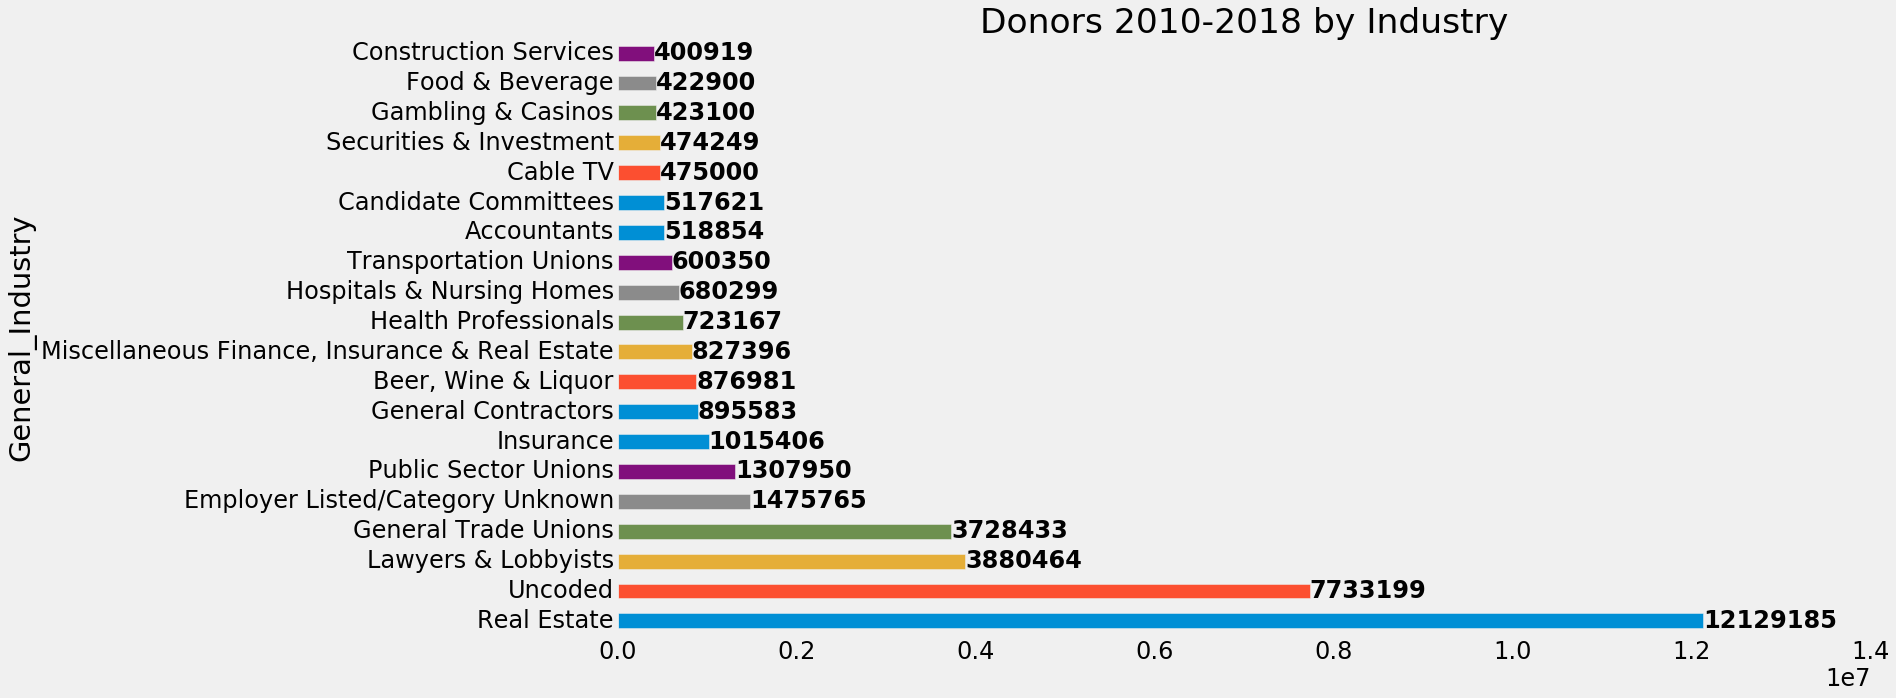

In [36]:
plt.figure(figsize=(20,10))
ax = df.groupby('General_Industry')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='General_Industry', kind='barh')

#Direct labels
for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
ax.set_title("Donors 2010-2018 by Industry")

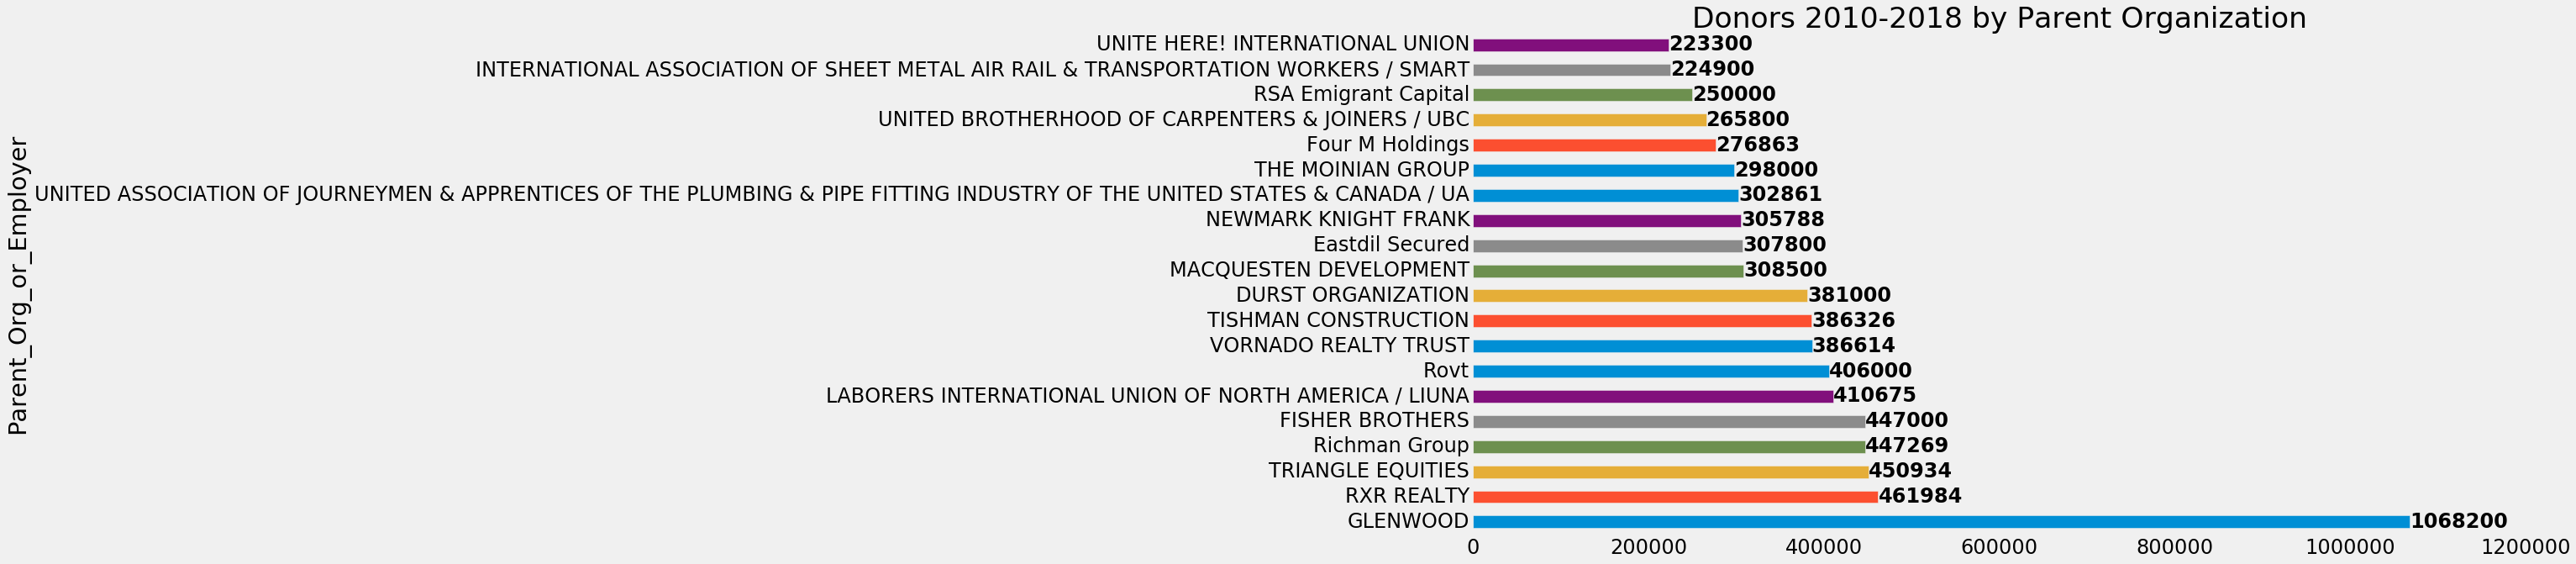

In [37]:
plt.figure(figsize=(20,10))
ax=df['2010-01-01':]\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values(ascending=False).head(20)\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

#Direct labels
for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
ax.set_title("Donors 2010-2018 by Parent Organization")

(0.0, 100.0, 0.0, 100.0)

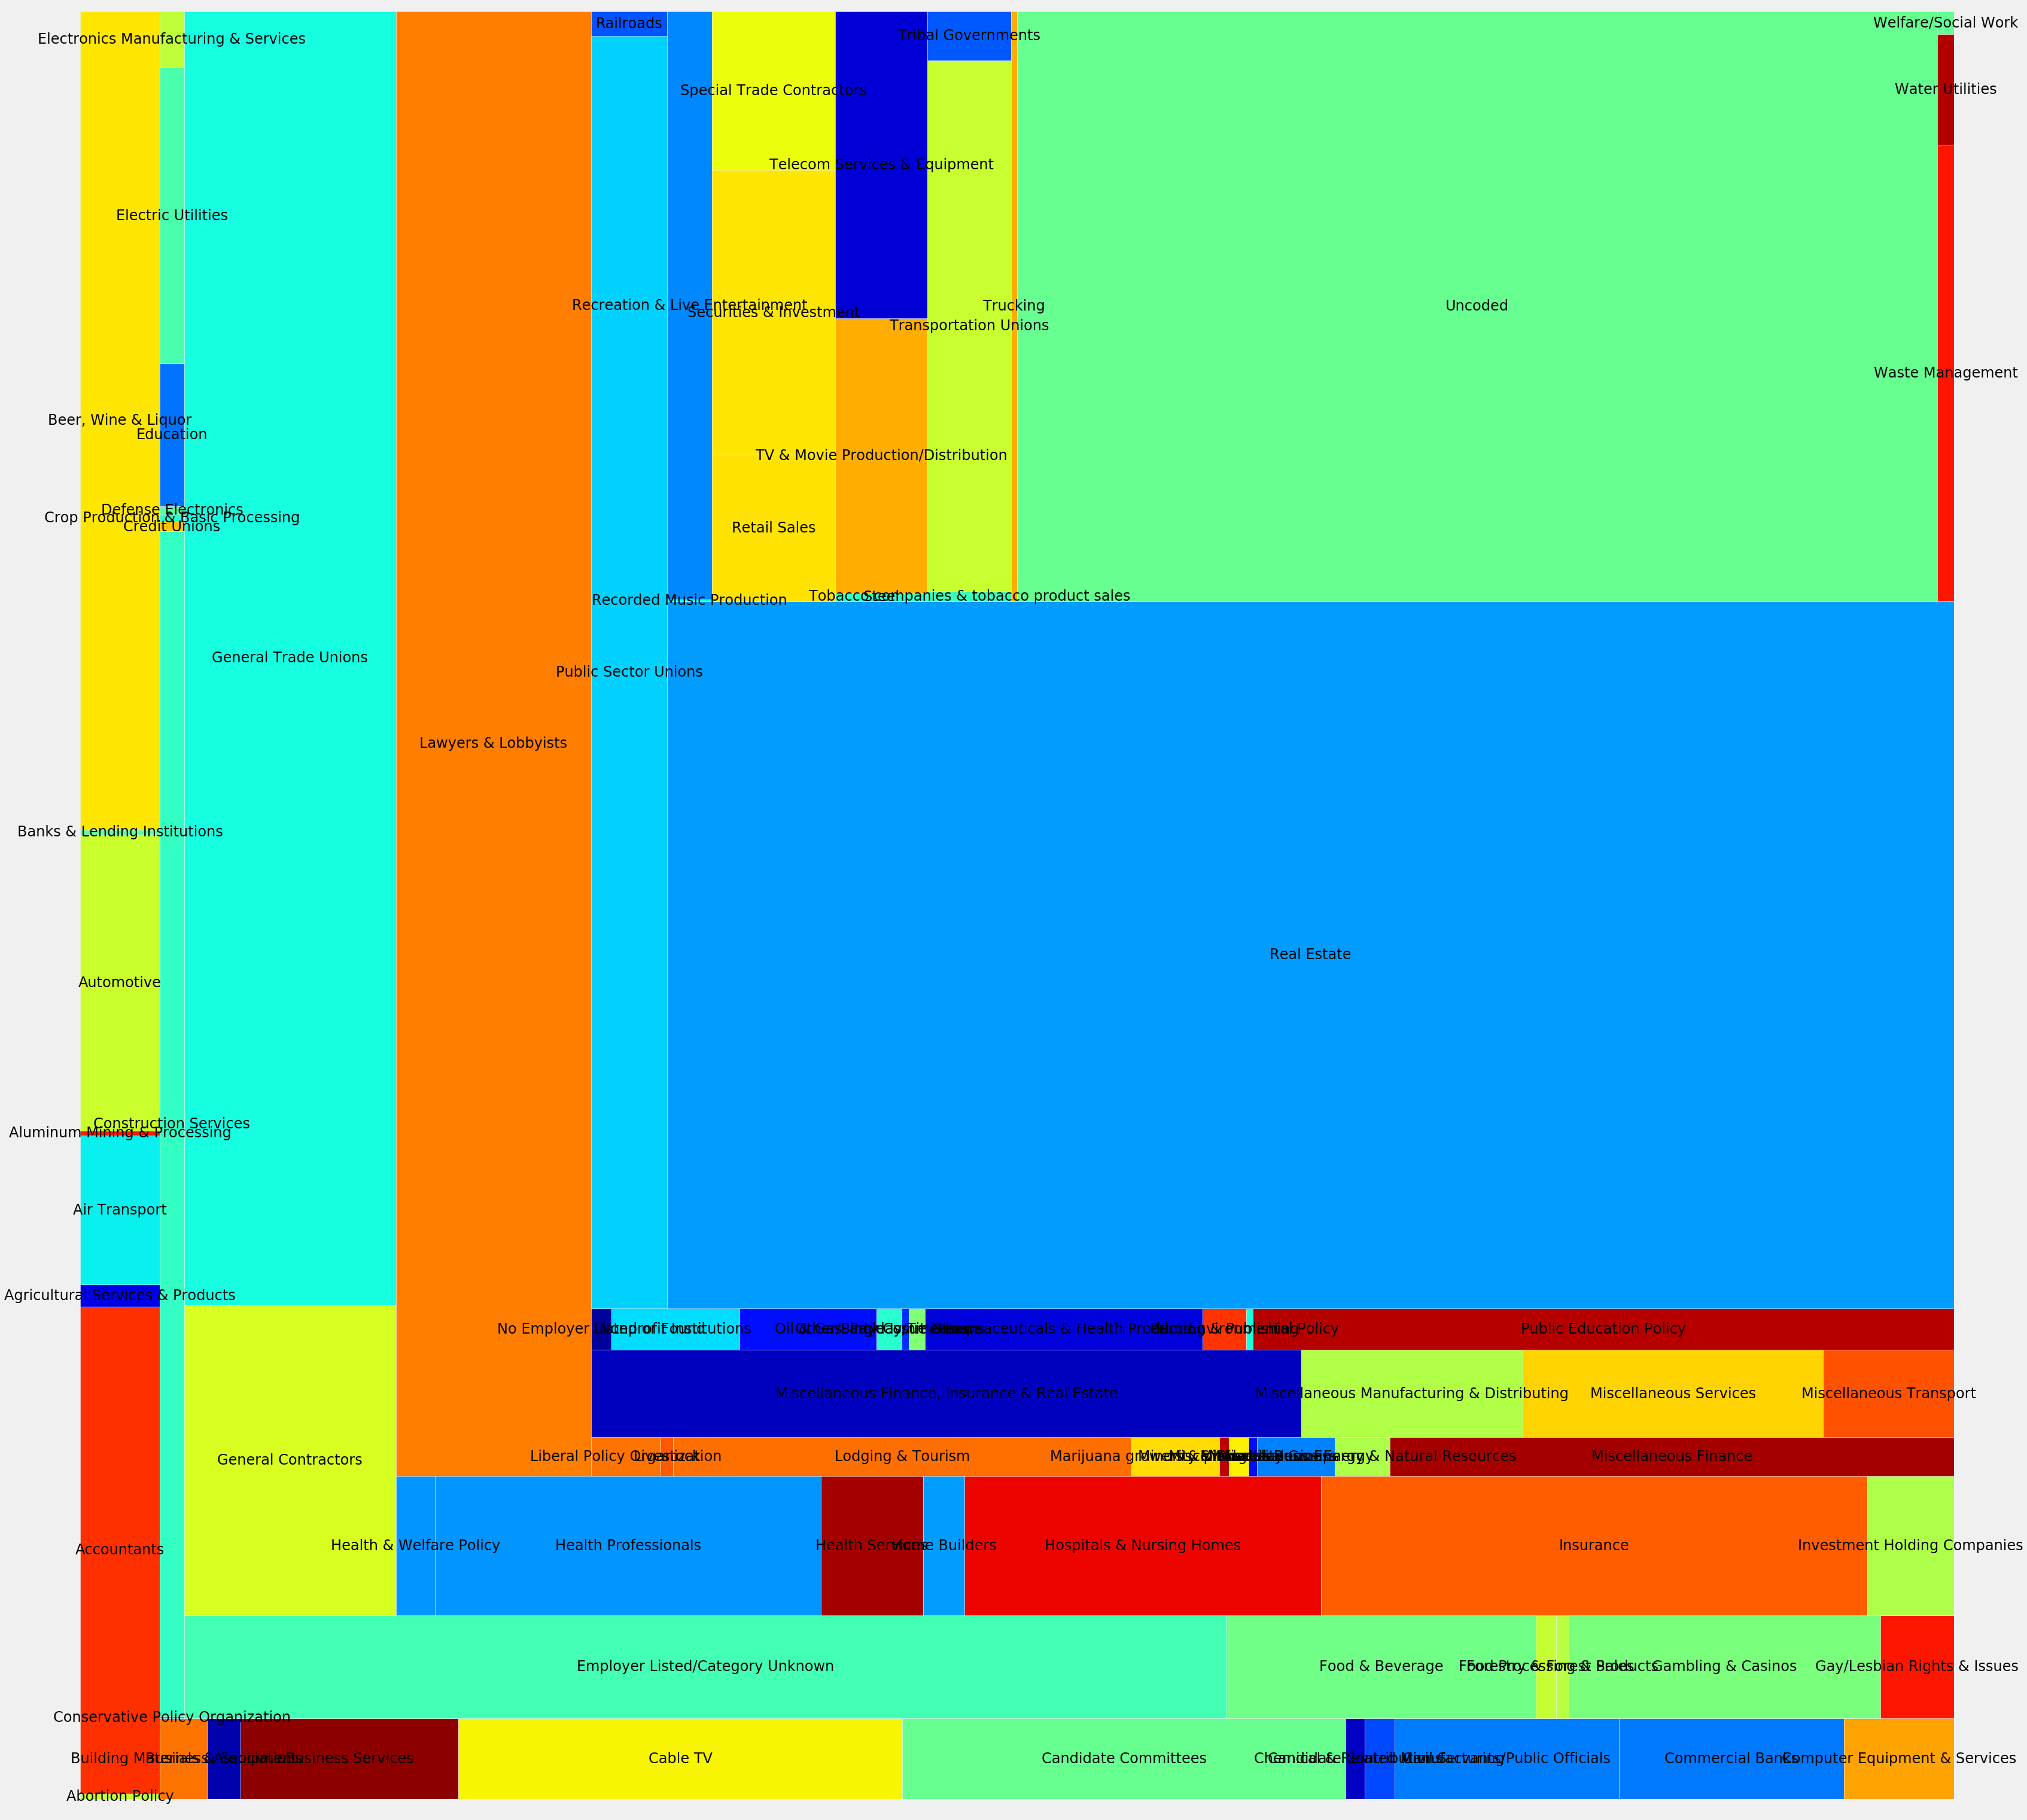

In [38]:
plt.figure(figsize=(10,10))
squares = df['2010-01-01':].groupby('General_Industry')['Amount_boe'].sum().to_frame().reset_index()
squares = squares.groupby('General_Industry')['Amount_boe'].sum().to_frame().reset_index()

# If you have a data frame?
plt.figure(figsize=(50,50))
squarify.plot(sizes=squares['Amount_boe'], label=squares['General_Industry'] )
plt.axis('off')


In [39]:
rec = df['2010-01-01':]
print("In addition to the $6,205,116.61 from donor matching using Follow the Money's historical data,\
I found","${:,}".format(round(float(rec[rec['General_Industry']=='Real Estate']['Amount_boe'].sum())-float(6205116.61), 2))\
      ,"in Real Estate cash by matching for REBNY/RSA members, as well as LLC owner-matching from DOB records.")
df[df['General_Industry']=='Real Estate']['Amount_boe'].sum()

In addition to the $6,205,116.61 from donor matching using Follow the Money's historical data,I found $5,829,568.0 in Real Estate cash by matching for REBNY/RSA members, as well as LLC owner-matching from DOB records.


12129184.61

In [40]:
print("Cuomo has accepted",\
      "${:,}".format(rec[rec['General_Industry']=='Real Estate']['Amount_boe'].sum())\
     ,"from the Real Estate industry during his time in the Governor's office.")

Cuomo has accepted $12,034,684.61 from the Real Estate industry during his time in the Governor's office.


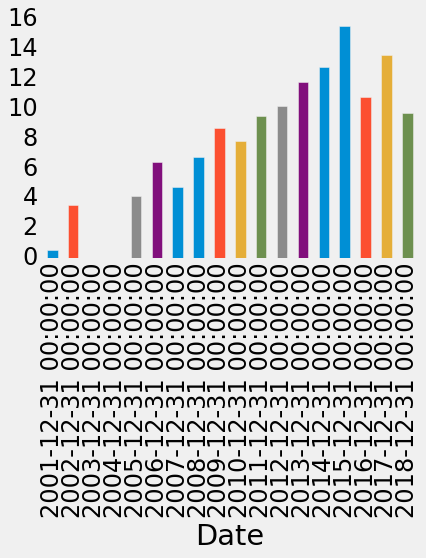

In [41]:
perc = rec[(rec['General_Industry']=='Real Estate')|\
           (rec['General_Industry']=='Miscellaneous Finance, Insurance & Real Estate')]\
.resample('Y')['Amount_boe'].sum()/rec.resample('Y')['Amount_boe'].sum() * 100 
perc.plot(kind='bar')

In [42]:
df.loc[df['General_Industry']=='Real Estate', 'Broad_Sector']='Finance, Insurance & Real Estate'
rec = df['2010-01-01':]
rec = rec.fillna({'Parent_Org_or_Employer':'Unknown Parent Org'})

##### I decided to exclude donors from the visualization where no industry information was known.
rec = rec[~rec['General_Industry'].str.contains('Uncoded', na=False)]

In [43]:
rec = rec.groupby(['General_Industry','Parent_Org_or_Employer','Donor'])\
['Amount_boe'].sum().to_frame()

In [44]:
grouped = rec
results = defaultdict(lambda: defaultdict(dict))
for t in grouped.itertuples():
    for i, key in enumerate(t.Index):
        if i ==0:
            nested = results[key]
        elif i == len(t.Index) -1:
            nested[key] = t
        else: nested = nested[key]

json_output = json.dumps(results, indent = 4)
data = json.loads(json_output)
for key in data:
    for nest_key in data[key].keys():
        for nest_nest_key in data[key][nest_key].keys():
            del data[key][nest_key][nest_nest_key][0]

ind_list = []
for key in data:
    ind_dict = {}
    ind_dict['name']=key
    comp_list = []
    for nest_key in data[key].keys():
        comp_dict = {}
        comp_dict['name']=nest_key
        little_list = []
        for k,v in data[key][nest_key].items():
            donor_dict={}
            donor_dict['name']=k
            donor_dict['size']=v[0]
            little_list.append(donor_dict)
        comp_dict['children']=little_list
        comp_list.append(comp_dict)
    ind_dict['children']=comp_list
    ind_list.append(ind_dict)
    
big_dict = {}
big_dict['name']='Cuomo'
big_dict['children']=ind_list
with open('data.json', 'w') as outfile:
    json.dump(big_dict, outfile)

In [46]:
df[df['Parent_Org_or_Employer']=='RSA']

,Donor,Address,Check No.,Amount_boe,Date_boe,Recipient,Fiscal Report,Filer,Original_Name,Contributor,...,Unnamed: 0,firm,name,rebny,donor,dob_ownername,dob_business,dob_address,dob_ownersphone,Donation_Date
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-04,RSA-PAC,"123 WILLIAM STREET NEW YORK, NY, 10038",4210,5000.0,06/04/2007,ANDREW CUOMO 2018 INC.,Periodic July,"CUOMO, ANDREW M",RSA-PAC,RENT STABILIZATION ASSOCIATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-04
2006-09-21,RSA-PAC,"123 WILLIAM STREET NEW YORK, NY, 10038",4139,25000.0,09/21/2006,ANDREW CUOMO FOR ATTORNEY GENERAL INC.,32 Day Pre General,"CUOMO, ANDREW M",RSA-PAC,RENT STABILIZATION ASSOCIATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-21
2014-07-02,MICHAEL KERR,"76 WOOD LANE WOODMERE, NY, 11598",6346,10000.0,07/02/2014,ANDREW CUOMO 2018 INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-02
2009-06-15,MICHAEL KERR,"76 WOOD LANE WOODSBURGH, NY, 11598",4149,10000.0,06/15/2009,ANDREW CUOMO 2018 INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-06-15
2010-06-20,MICHAEL KERR,"76 WOOD LANE WOODSBURGH, NY, 11598",4690,15000.0,06/20/2010,ANDREW CUOMO 2018 INC.,Periodic July,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-20
2007-08-26,MICHAEL KERR,"76 WOODS LANE WOODMERE, NY, 11598",3223,2500.0,08/26/2007,ANDREW CUOMO 2018 INC.,Periodic Jan.,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-26
2008-12-02,MICHAEL KERR,"76 WOOD LANE WOODMERE, NY, 11598",3857,10000.0,12/02/2008,ANDREW CUOMO 2018 INC.,Periodic Jan.,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-12-02
2008-11-24,RSA-PAC,"123 WILLIAM STREET NEW YORK, NY, 10038",4344,5000.0,11/24/2008,ANDREW CUOMO 2018 INC.,Periodic Jan.,"CUOMO, ANDREW M",RSA-PAC,RENT STABILIZATION ASSOCIATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-11-24
2007-12-28,RSA-PAC,"123 WILLIAM STREET NEW YORK, NY, 10038",4249,5000.0,12/28/2007,ANDREW CUOMO 2018 INC.,Periodic Jan.,"CUOMO, ANDREW M",RSA-PAC,RENT STABILIZATION ASSOCIATION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-28
